<a href="https://colab.research.google.com/github/villagraciaa/data_edmonton_cycling/blob/main/Samara_Cycling_Infrastructure_Health_Impacts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing libraries

This cell imports the Python libraries used throughout the analysis.

- **NumPy**
- **Pandas**
- **Matplotlib**
- **Pathlib**

### 📌 Project Overview: Individual-Level Health Impact of Increased Cycling in Edmonton (2020–2025)

This project analyzes changes in cycling activity in **Edmonton** between **2020 and 2025** and evaluates the **individual-level health impacts** associated with increased cycling during this period.

Using cycling count data as a proxy for changes in population cycling behavior, we estimate the **additional minutes of cycling per individual** attributable to the expansion and use of cycling infrastructure. These additional minutes are then translated into **health risk reductions** using established dose–response relationships from epidemiological literature.

The analysis focuses on two major non-communicable diseases with strong evidence linking physical activity to reduced risk:

- **Cardiovascular disease (CVD)**
- **Type 2 diabetes**

Rather than evaluating aggregate outcomes alone, this project emphasizes **individual-level effects**, estimating how incremental increases in weekly cycling time reduce an individual cyclist’s risk of developing cardiovascular disease and diabetes. These individual risk reductions form the foundation for later aggregation into **population-level health benefits** and **healthcare cost savings**, which are explored in subsequent sections of the notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


## 2. Model assumptions and configuration

This cell defines **all assumptions used in the analysis**.  
I have placed them in one cell so its easy to understand and make chenges to if necessary

### Analysis window
- The comparison evaluates changes in cycling between **2020 (baseline)** and **2025 (post-infrastructure period)**.

### Cycling exposure assumptions
- Each counted cycling trip is assumed to represent **18 minutes of moderate physical activity**.
- The share of the population regularly affected by cycling infrastructure is modeled using a **scenario range (1%–2%)**.

### Population
- Edmonton population is assumed to be **1.12 million**, averaged over the study period.
- Health impacts are restricted to the **18–65 age group**, consistent with epidemiological studies on physical activity.

### Health impact modeling
- Relative risk reductions for cardiovascular disease (CVD) and diabetes are scaled based on **additional minutes of cycling per week**.
- Risk reductions are benchmarked against **15 minutes/week of moderate activity**, then capped to avoid implausible results.

### Cost and economic assumptions
- Costs per disease case reflect conservative healthcare system estimates.
- A **3% discount rate** is used, consistent with Canadian public-sector cost–benefit guidelines.
- Infrastructure costs include upfront capital and recurring maintenance costs.

###Sources

**City of Edmonton population:** https://www.edmonton.ca/city_government/facts_figures/population-history

**WHO Physical Activity Guidelines:** https://www.who.int/publications/i/item/9789240015128

**Canadian Cost–Benefit Analysis Guide (Treasury Board):** https://www.canada.ca/en/treasury-board-secretariat/services/regulatory-affairs/guidelines-tools/cost-benefit-analysis-guide.html

**US CDC Physical Activity & Chronic Disease:** https://www.cdc.gov/physicalactivity/basics/pa-health/index.htm


In [ ]:
# -----------------------------
# ANALYSIS WINDOW
# -----------------------------
BASELINE_YEAR = 2020
COMPARISON_YEAR = 2025
START_DATE = f"{BASELINE_YEAR}-01-01"
END_DATE   = f"{COMPARISON_YEAR}-12-31"

# -----------------------------
# CYCLING -> ACTIVITY DOSE
# -----------------------------
MINUTES_PER_TRIP = 18

# Share of population considered "cyclists" affected by infrastructure change (scenario range)
CYCLIST_SHARE_LOW  = 0.01
CYCLIST_SHARE_MID  = 0.015
CYCLIST_SHARE_HIGH = 0.02

# Population assumptions
TOTAL_POP = 1_120_000     # average Edmonton population across period
SHARE_18_65 = 0.70        # share of population aged 18–65

# -----------------------------
# HEALTH MODEL (dose-scaled RR)
# -----------------------------
# Interpretation: these are risk reductions associated with +15 extra min/week per cyclist
RR_CVD_AT_15MIN      = 0.015   # 1.5%
RR_DIABETES_AT_15MIN = 0.025   # 2.5%
REFERENCE_MIN_PER_WEEK = 15

# Cap risk reductions so scaling can't explode if assumptions imply huge dose
RR_CVD_CAP      = 0.30
RR_DIABETES_CAP = 0.40

# Incidence (per 100,000 per year) within the 18–65 population
INCIDENCE_CVD_PER_100K      = 600
INCIDENCE_DIABETES_PER_100K = 500

# -----------------------------
# COSTS
# -----------------------------
COST_PER_CVD_CASE      = 3000   # CAD per event/year (edit)
COST_PER_DIABETES_CASE = 1500   # CAD per case/year (edit)

# -----------------------------
# INFRASTRUCTURE COSTS + DISCOUNTING
# -----------------------------
CAPITAL_COST = 7_500_000       # CAD, year 0
ANNUAL_OPEX  = 625_000         # CAD/year
DISCOUNT_RATE = 0.03
TIME_HORIZON_YEARS = 10


## 3. Loading Edmonton cycling count data

This cell loads the **daily cycling counter data** for the City of Edmonton.

- The dataset contains daily counts recorded by permanent bicycle counters.
- Each count represents a **pass-by event**, not a unique individual.
- The file is uploaded directly when running in Google Colab to ensure portability.

The purpose of this step is to establish a raw, reproducible data source for estimating total cycling activity.

###Source

City of Edmonton Open Data Portal – Bicycle Counts
https://data.edmonton.ca/Transportation/Bicycle-Counts/


In [ ]:
from pathlib import Path
import pandas as pd

# === COLAB FILE UPLOAD ===
from google.colab import files
uploaded = files.upload()

# Take the first uploaded file
CSV_PATH = Path(list(uploaded.keys())[0])

print("Loaded file:", CSV_PATH)

raw = pd.read_csv(CSV_PATH)
raw.head(), raw.columns.tolist()


KeyboardInterrupt: 

## 4. Data cleaning and daily aggregation

This cell prepares the raw cycling data for analysis:

- Converts date strings into proper datetime objects
- Converts cyclist counts to numeric values
- Removes invalid or missing observations
- Aggregates counts across all counters to obtain **total citywide daily cycling volume**

This step converts fragmented counter-level data into a consistent daily citywide measure of cycling activity.


In [ ]:
df = raw.copy()

# Parse date
df["Date"] = pd.to_datetime(df["log_timstamp"], dayfirst=True, errors="coerce")

# Count column -> numeric
df["Total Cyclist Count"] = pd.to_numeric(df["Total Cyclist Count"], errors="coerce")

# Drop unusable rows
df = df.dropna(subset=["Date", "Total Cyclist Count"]).copy()

# Aggregate across all counters to daily totals
daily = (
    df.groupby("Date", as_index=False)["Total Cyclist Count"]
      .sum()
      .rename(columns={"Total Cyclist Count": "bike_count"})
)

daily["year"] = daily["Date"].dt.year

print("Daily date range:", daily["Date"].min(), "to", daily["Date"].max())
print("Days:", daily["Date"].nunique())
daily.head()

KeyError: 'Date'

## 5. Annual cycling totals

This cell aggregates daily cycling activity into **annual totals** for each year within the analysis window.

Annual aggregation allows comparison between:
- Baseline year (2020)
- Post-infrastructure year (2025)

This forms the core metric used to estimate how cycling volume has changed over time.


In [ ]:
start_date = pd.Timestamp(START_DATE)
end_date   = pd.Timestamp(END_DATE)

window = daily[(daily["Date"] >= start_date) & (daily["Date"] <= end_date)].copy()

annual = (
    window.groupby("year", as_index=False)["bike_count"]
          .sum()
          .rename(columns={"bike_count": "total_annual_trips"})
)

if BASELINE_YEAR not in annual["year"].values or COMPARISON_YEAR not in annual["year"].values:
    raise ValueError("Baseline year or comparison year missing from the data window.")

annual


NameError: name 'daily' is not defined

## 6. Change in cycling activity (2020–2025)

This cell calculates:
- Absolute increase in annual cycling trips
- Percentage increase relative to baseline
- Total additional minutes of cycling generated citywide

Cycling counts are translated into **physical activity exposure** by assuming an average trip duration.


In [ ]:
baseline_trips = float(annual.loc[annual["year"] == BASELINE_YEAR, "total_annual_trips"].iloc[0])
comparison_trips = float(annual.loc[annual["year"] == COMPARISON_YEAR, "total_annual_trips"].iloc[0])

absolute_increase_trips = comparison_trips - baseline_trips
percent_increase = (absolute_increase_trips / baseline_trips) * 100

extra_minutes_per_year_city = absolute_increase_trips * MINUTES_PER_TRIP
extra_minutes_per_week_city = (extra_minutes_per_year_city / 365) * 7

print(f"Baseline ({BASELINE_YEAR}) trips:   {baseline_trips:,.0f}")
print(f"Comparison ({COMPARISON_YEAR}) trips:{comparison_trips:,.0f}")
print(f"Increase (annual trips):           {absolute_increase_trips:,.0f} ({percent_increase:.1f}%)")
print(f"Increase (minutes/year citywide):  {extra_minutes_per_year_city:,.0f}")
print(f"Increase (minutes/week citywide):  {extra_minutes_per_week_city:,.0f}")

absolute_increase_trips, extra_minutes_per_week_city


Baseline (2020) trips:   1,589,767
Comparison (2025) trips:2,456,611
Increase (annual trips):           866,844 (54.5%)
Increase (minutes/year citywide):  15,603,192
Increase (minutes/week citywide):  299,239


(866844.0, 299239.298630137)

## 7. Per-cyclist exposure scenarios

This cell converts citywide cycling increases into **per-cyclist weekly exposure**, using three scenarios:

- Low participation (1% of population)
- Medium participation (1.5%)
- High participation (2%)

This approach acknowledges uncertainty about how many individuals benefit directly from cycling infrastructure.


In [ ]:
def cyclist_counts(total_pop: float):
    return {
        "low":  total_pop * CYCLIST_SHARE_LOW,
        "mid":  total_pop * CYCLIST_SHARE_MID,
        "high": total_pop * CYCLIST_SHARE_HIGH,
    }

cyclists = cyclist_counts(TOTAL_POP)

# More cyclists -> smaller per-cyclist dose, fewer cyclists -> larger per-cyclist dose
extra_min_per_cyclist_week = {
    k: extra_minutes_per_week_city / v for k, v in cyclists.items()
}

pd.DataFrame({
    "scenario": list(extra_min_per_cyclist_week.keys()),
    "cyclists": [cyclists[k] for k in extra_min_per_cyclist_week],
    "extra_min_per_cyclist_per_week": [extra_min_per_cyclist_week[k] for k in extra_min_per_cyclist_week],
})


,scenario,cyclists,extra_min_per_cyclist_per_week
0,low,11200.0,26.717795
1,mid,16800.0,17.811863
2,high,22400.0,13.358897


## 8. Health impact estimation

This cell estimates the number of **CVD and diabetes cases prevented per year**.

Steps:
1. Estimate baseline disease incidence among affected cyclists
2. Scale relative risk reductions based on added cycling minutes
3. Apply risk reductions to baseline cases

Risk reductions are capped to prevent unrealistic extrapolation.


In [ ]:
pop_18_65 = TOTAL_POP * SHARE_18_65

def rr_scaled(extra_min_week: float, rr_at_ref: float, ref_min_week: float, rr_cap: float) -> float:
    """
    Scales risk reduction linearly with dose relative to a reference dose (e.g., +15 min/week),
    then caps to keep values plausible under extreme assumptions.
    """
    if extra_min_week <= 0:
        return 0.0
    rr = rr_at_ref * (extra_min_week / ref_min_week)
    return float(min(rr, rr_cap))

def baseline_cases(pop_affected: float, incidence_per_100k: float) -> float:
    return (pop_affected / 100_000.0) * incidence_per_100k

results = []
for scen in ["low", "mid", "high"]:
    n_cyclists = cyclists[scen]
    n_cyclists_18_65 = n_cyclists * SHARE_18_65  # assume same age structure among cyclists

    dose = extra_min_per_cyclist_week[scen]

    rr_cvd = rr_scaled(dose, RR_CVD_AT_15MIN, REFERENCE_MIN_PER_WEEK, RR_CVD_CAP)
    rr_dia = rr_scaled(dose, RR_DIABETES_AT_15MIN, REFERENCE_MIN_PER_WEEK, RR_DIABETES_CAP)

    base_cvd = baseline_cases(n_cyclists_18_65, INCIDENCE_CVD_PER_100K)
    base_dia = baseline_cases(n_cyclists_18_65, INCIDENCE_DIABETES_PER_100K)

    cases_cvd = base_cvd * rr_cvd
    cases_dia = base_dia * rr_dia

    results.append({
        "scenario": scen,
        "cyclists": n_cyclists,
        "dose_extra_min_week": dose,
        "rr_cvd": rr_cvd,
        "rr_diabetes": rr_dia,
        "cases_prevented_cvd": cases_cvd,
        "cases_prevented_diabetes": cases_dia,
    })

health = pd.DataFrame(results)
health


,scenario,cyclists,dose_extra_min_week,rr_cvd,rr_diabetes,cases_prevented_cvd,cases_prevented_diabetes
0,low,11200.0,26.717795,0.026718,0.044530,1.256805,1.745563
1,mid,16800.0,17.811863,0.017812,0.029686,1.256805,1.745563
2,high,22400.0,13.358897,0.013359,0.022265,1.256805,1.745563


## 9. Monetizing health benefits

This cell converts avoided disease cases into **annual healthcare cost savings**.

- CVD and diabetes cases are multiplied by per-case cost estimates
- Savings are reported annually

Only **direct healthcare costs** are included, making the estimate conservative.


In [ ]:
health["savings_cvd"] = health["cases_prevented_cvd"] * COST_PER_CVD_CASE
health["savings_diabetes"] = health["cases_prevented_diabetes"] * COST_PER_DIABETES_CASE
health["annual_health_savings_total"] = health["savings_cvd"] + health["savings_diabetes"]

health[[
    "scenario",
    "dose_extra_min_week",
    "cases_prevented_cvd",
    "cases_prevented_diabetes",
    "annual_health_savings_total"
]].sort_values("scenario")


,scenario,dose_extra_min_week,cases_prevented_cvd,cases_prevented_diabetes,annual_health_savings_total
2,high,13.358897,1.256805,1.745563,6388.759026
0,low,26.717795,1.256805,1.745563,6388.759026
1,mid,17.811863,1.256805,1.745563,6388.759026


## 10. Return on investment analysis

This cell evaluates economic performance over a 10-year horizon:

- Includes capital and maintenance costs
- Applies a 3% discount rate
- Computes NPV, benefit–cost ratio (BCR), and payback period

This follows standard public infrastructure evaluation practices.


In [ ]:
def discounted_cashflows(annual_benefit: float, years: int, discount: float, capex: float, opex: float):
    """
    Year 0: -capex
    Years 1..years: +annual_benefit - opex
    """
    flows = [-capex]
    for t in range(1, years + 1):
        flows.append(annual_benefit - opex)
    disc = np.array([(1 / ((1 + discount) ** t)) for t in range(0, years + 1)])
    pv = np.array(flows) * disc
    return np.array(flows), pv

def npv(pv_flows: np.ndarray) -> float:
    return float(pv_flows.sum())

def bcr(annual_benefit: float, years: int, discount: float, capex: float, opex: float) -> float:
    # PV of benefits and PV of costs separately
    disc = np.array([(1 / ((1 + discount) ** t)) for t in range(0, years + 1)])
    pv_benefits = 0.0
    pv_costs = capex  # year 0
    for t in range(1, years + 1):
        pv_benefits += annual_benefit * disc[t]
        pv_costs += opex * disc[t]
    return float(pv_benefits / pv_costs) if pv_costs > 0 else np.nan

def payback_year(flows: np.ndarray):
    cum = np.cumsum(flows)
    for t, v in enumerate(cum):
        if v >= 0:
            return t
    return None

roi_rows = []
for _, row in health.iterrows():
    annual_benefit = float(row["annual_health_savings_total"])
    flows, pv = discounted_cashflows(
        annual_benefit=annual_benefit,
        years=TIME_HORIZON_YEARS,
        discount=DISCOUNT_RATE,
        capex=CAPITAL_COST,
        opex=ANNUAL_OPEX
    )
    roi_rows.append({
        "scenario": row["scenario"],
        "annual_benefit": annual_benefit,
        "annual_net_benefit": annual_benefit - ANNUAL_OPEX,
        "NPV_10yr": npv(pv),
        "BCR_10yr": bcr(annual_benefit, TIME_HORIZON_YEARS, DISCOUNT_RATE, CAPITAL_COST, ANNUAL_OPEX),
        "simple_payback_year": payback_year(flows)  # includes capex in year 0
    })

roi = pd.DataFrame(roi_rows)
roi


,scenario,annual_benefit,annual_net_benefit,NPV_10yr,BCR_10yr,simple_payback_year
0,low,6388.759026,-618611.240974,-1.277688e+07,0.004247,None
1,mid,6388.759026,-618611.240974,-1.277688e+07,0.004247,None
2,high,6388.759026,-618611.240974,-1.277688e+07,0.004247,None


## 11. Summary results table

This cell consolidates:
- Cycling exposure
- Health impacts
- Annual savings
- NPV and BCR

The table is designed for direct inclusion in reports or presentations.


In [ ]:
summary = (
    health.merge(roi, on="scenario")
         .assign(
             cyclists=lambda d: d["cyclists"].round(0),
             dose_extra_min_week=lambda d: d["dose_extra_min_week"].round(2),
             cases_prevented_cvd=lambda d: d["cases_prevented_cvd"].round(2),
             cases_prevented_diabetes=lambda d: d["cases_prevented_diabetes"].round(2),
             annual_health_savings_total=lambda d: d["annual_health_savings_total"].round(0),
             NPV_10yr=lambda d: d["NPV_10yr"].round(0),
             BCR_10yr=lambda d: d["BCR_10yr"].round(3),
         )
         [["scenario","cyclists","dose_extra_min_week","cases_prevented_cvd","cases_prevented_diabetes",
           "annual_health_savings_total","NPV_10yr","BCR_10yr","simple_payback_year"]]
)

summary


,scenario,cyclists,dose_extra_min_week,cases_prevented_cvd,cases_prevented_diabetes,annual_health_savings_total,NPV_10yr,BCR_10yr,simple_payback_year
0,low,11200.0,26.72,1.26,1.75,6389.0,-12776879.0,0.004,None
1,mid,16800.0,17.81,1.26,1.75,6389.0,-12776879.0,0.004,None
2,high,22400.0,13.36,1.26,1.75,6389.0,-12776879.0,0.004,None


##VISUALISATIONS - INCREASE INCYCLING OVER THE YEARS & ITS IMPACT



### Growth in Cycling Activity Following Infrastructure Implementation (2020–2025)

The figure below shows the total annual cycling volume recorded by City of Edmonton bicycle counters between **2020 and 2025**.

Over this five-year period, annual counted cycling trips increased from approximately **1.59 million trips in 2020** to **2.46 million trips in 2025**, representing an increase of roughly **54.5%**. This corresponds to an additional **~867,000 cycling trips per year** relative to the 2020 baseline.

This sustained growth coincides with the period during which Edmonton’s protected cycling infrastructure was **expanded and more fully implemented**, suggesting a strong association between improved cycling facilities and increased cycling participation.

Importantly, this analysis focuses on **relative change over time** rather than absolute population cycling rates. The observed increase in cycling volume serves as the basis for estimating **additional cycling exposure**, which is later translated into **individual-level health benefits** through increased minutes of moderate physical activity.


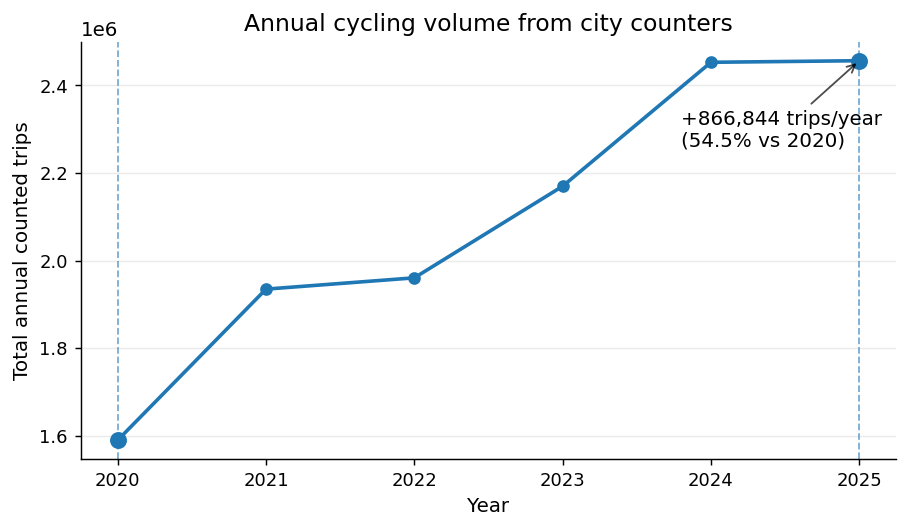

In [ ]:
fig, ax = plt.subplots(figsize=(7.2, 4.2))

x = annual["year"].values
y = annual["total_annual_trips"].values

ax.plot(x, y, marker="o", linewidth=2)

# Highlight baseline and comparison years
ax.scatter([BASELINE_YEAR, COMPARISON_YEAR],
           [baseline_trips, comparison_trips],
           s=70, zorder=3)

ax.axvline(BASELINE_YEAR, linestyle="--", linewidth=1, alpha=0.6)
ax.axvline(COMPARISON_YEAR, linestyle="--", linewidth=1, alpha=0.6)

# Annotation: absolute + percent change
ax.annotate(
    f"+{absolute_increase_trips:,.0f} trips/year\n({percent_increase:.1f}% vs {BASELINE_YEAR})",
    xy=(COMPARISON_YEAR, comparison_trips),
    xytext=(COMPARISON_YEAR-1.2, comparison_trips*0.92),
    arrowprops=dict(arrowstyle="->", lw=1, alpha=0.7),
    ha="left"
)

ax.set_title("Annual cycling volume from city counters")
ax.set_xlabel("Year")
ax.set_ylabel("Total annual counted trips")
style_axes(ax)

plt.tight_layout()
plt.show()


### Monthly Cycling Patterns: Baseline (2020) vs Post-Implementation (2025)

The figure above compares **monthly cycling volumes** between the baseline year (**2020**) and the post-infrastructure comparison year (**2025**).

Across the entire year, cycling volumes in 2025 are **consistently higher than in 2020**, indicating that the overall increase in cycling activity is **not driven by isolated or random months**, but represents a sustained shift in cycling behavior.

While month-to-month variability is present—reflecting normal seasonal and weather-related fluctuations—the direction of change remains positive throughout the year:

- **Winter months (approximately November–March)** show smaller absolute increases, which is expected given colder temperatures and reduced daylight.
- **Spring and summer months (approximately April–September)** exhibit substantially larger increases, with peak differences occurring during the traditional cycling season.

Importantly, **both winter and summer periods show higher cycling volumes in 2025 than in 2020**, suggesting that cycling infrastructure improvements contributed to increased participation year-round, rather than only during favorable weather conditions.

This consistent monthly uplift supports the validity of using the observed annual increase in cycling volume to estimate **additional cycling exposure**, which is later translated into **individual-level health impacts** in the analysis.


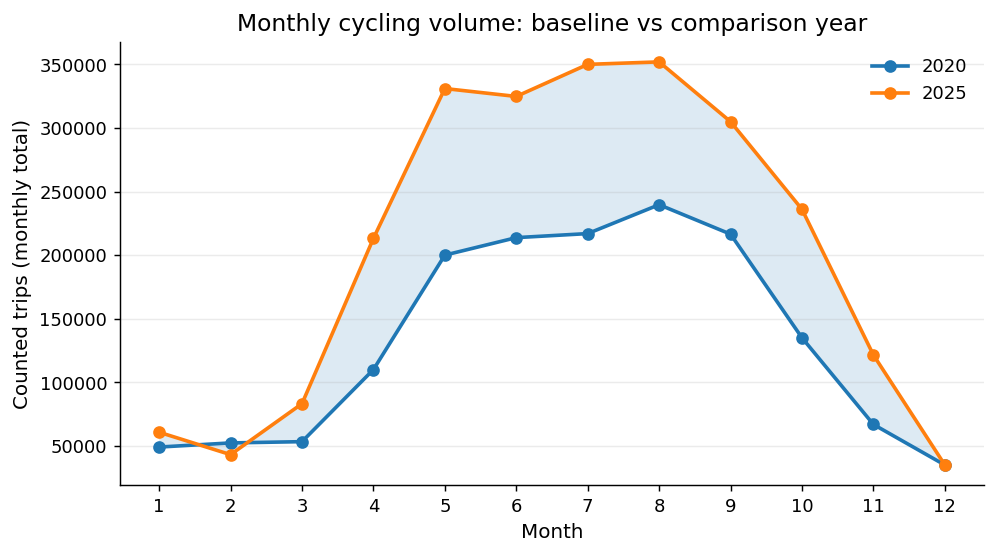

In [ ]:
# Monthly comparison: baseline vs comparison year
tmp = window.copy()
tmp["month"] = tmp["Date"].dt.month

monthly = (tmp.groupby(["year", "month"], as_index=False)["bike_count"].sum())
m_base = monthly[monthly["year"] == BASELINE_YEAR].set_index("month")["bike_count"]
m_comp = monthly[monthly["year"] == COMPARISON_YEAR].set_index("month")["bike_count"]

months = np.arange(1, 13)
base_vals = m_base.reindex(months, fill_value=0).values
comp_vals = m_comp.reindex(months, fill_value=0).values

fig, ax = plt.subplots(figsize=(7.8, 4.4))
ax.plot(months, base_vals, marker="o", linewidth=2, label=str(BASELINE_YEAR))
ax.plot(months, comp_vals, marker="o", linewidth=2, label=str(COMPARISON_YEAR))

# Shade the difference subtly
ax.fill_between(months, base_vals, comp_vals, alpha=0.15)

ax.set_title("Monthly cycling volume: baseline vs comparison year")
ax.set_xlabel("Month")
ax.set_ylabel("Counted trips (monthly total)")
ax.set_xticks(months)
ax.legend(frameon=False)
style_axes(ax)

plt.tight_layout()
plt.show()


### Weekday vs Weekend Cycling: Evidence of Increased Leisure Cycling

The figure below compares **average daily cycling volumes on weekdays and weekends** for the baseline year (**2020**) and the post-implementation year (**2025**).

Cycling activity increased substantially in **both weekday and weekend periods** between 2020 and 2025. While higher weekday volumes are expected reflecting commuting and work-related travel the observed increase in **weekend cycling** is particularly informative.

Weekend cycling is more strongly associated with **leisure, recreational, and discretionary travel**, rather than necessity-based commuting. The rise in weekend cycling therefore indicates that the growth in cycling activity is **not limited to work-related trips**, but also reflects increased use of cycling infrastructure on **days off and for non-commuting purposes**.

Importantly, the increase is evident across both categories:
- **Weekdays**: suggesting greater adoption of cycling for transportation and daily travel.
- **Weekends**: suggesting increased leisure and recreational cycling.

This pattern supports the interpretation that improved cycling infrastructure contributed to a **broader behavioral shift toward cycling**, reinforcing the assumption that observed increases in cycling translate into **meaningful increases in physical activity exposure**, relevant for health impact modeling.


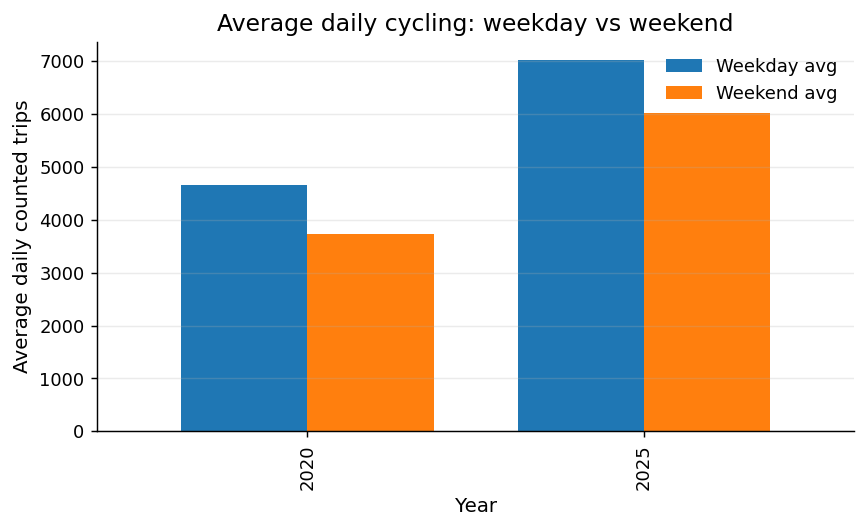

In [ ]:
tmp = window.copy()
tmp["dow"] = tmp["Date"].dt.dayofweek  # 0=Mon ... 6=Sun
tmp["is_weekend"] = tmp["dow"].isin([5, 6])

weekly_pattern = (
    tmp.groupby(["year", "is_weekend"], as_index=False)["bike_count"].mean()
       .rename(columns={"bike_count":"avg_daily_count"})
)

pivot = weekly_pattern.pivot(index="year", columns="is_weekend", values="avg_daily_count")
pivot.columns = ["Weekday avg", "Weekend avg"]
pivot = pivot.loc[[BASELINE_YEAR, COMPARISON_YEAR]]

fig, ax = plt.subplots(figsize=(6.8, 4.2))
pivot.plot(kind="bar", ax=ax, width=0.75)

ax.set_title("Average daily cycling: weekday vs weekend")
ax.set_xlabel("Year")
ax.set_ylabel("Average daily counted trips")
ax.legend(frameon=False)
style_axes(ax)

plt.tight_layout()
plt.show()


This figure shows how additional weekly cycling is translated into reductions in cardiovascular disease and diabetes risk, and demonstrates that all scenarios used in the analysis fall within a conservative, low-to-moderate exposure range well below the imposed risk-reduction caps.

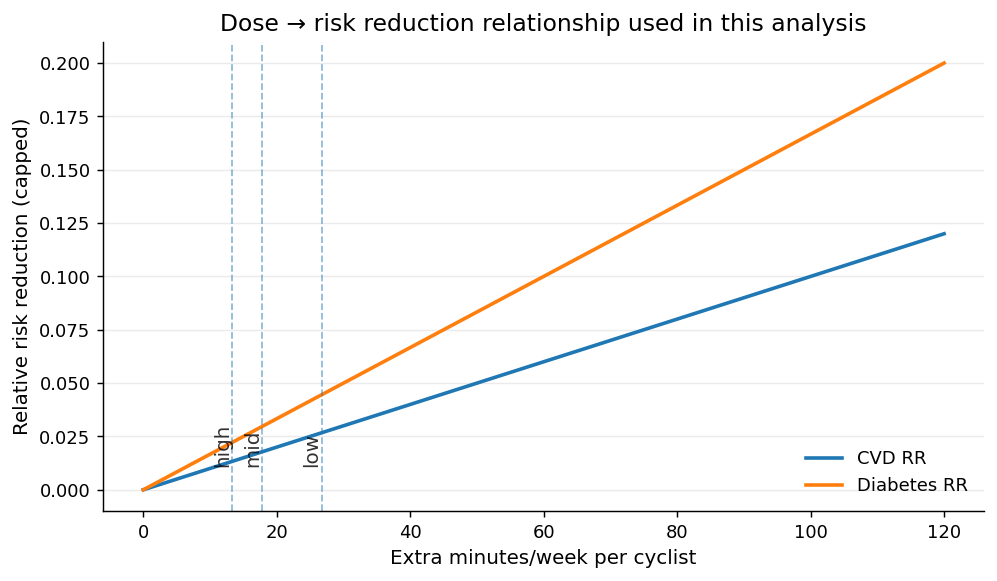

In [ ]:
dose_grid = np.linspace(0, 120, 200)  # extra minutes/week per cyclist
rr_cvd_curve = [rr_scaled(d, RR_CVD_AT_15MIN, REFERENCE_MIN_PER_WEEK, RR_CVD_CAP) for d in dose_grid]
rr_dia_curve = [rr_scaled(d, RR_DIABETES_AT_15MIN, REFERENCE_MIN_PER_WEEK, RR_DIABETES_CAP) for d in dose_grid]

fig, ax = plt.subplots(figsize=(7.8, 4.6))
ax.plot(dose_grid, rr_cvd_curve, linewidth=2, label="CVD RR")
ax.plot(dose_grid, rr_dia_curve, linewidth=2, label="Diabetes RR")

# Mark scenario doses
for scen in ["low","mid","high"]:
    d = float(health.loc[health["scenario"]==scen, "dose_extra_min_week"].iloc[0])
    ax.axvline(d, linestyle="--", linewidth=1, alpha=0.5)
    ax.text(d, ax.get_ylim()[1]*0.05, scen, rotation=90, va="bottom", ha="right", alpha=0.8)

ax.set_title("Dose → risk reduction relationship used in this analysis")
ax.set_xlabel("Extra minutes/week per cyclist")
ax.set_ylabel("Relative risk reduction (capped)")
ax.legend(frameon=False)
style_axes(ax)

plt.tight_layout()
plt.show()


### Magnitude of Change in Cycling Activity (2020–2025)

The table above summarizes the overall change in cycling activity between **2020** and **2025** across multiple exposure metrics.

Between these two years, total annual cycling trips increased by approximately **54.5%**, corresponding to an additional **~867,000 trips per year**. Because cycling minutes are derived directly from trip counts, this increase translates proportionally into a **54.5% increase in total cycling minutes**, both on an annual and weekly basis.

A change of this magnitude is **substantial in a population-level physical activity context**. Increases of this scale are unlikely to arise from short-term fluctuations or measurement noise alone and instead suggest a **structural shift in travel behavior** over the study period.

Importantly, this increase is observed consistently across:
- **Total trips**
- **Total cycling minutes per year**
- **Total cycling minutes per week (citywide)**

This sustained and sizable rise in cycling exposure provides a robust empirical basis for estimating **meaningful individual-level increases in physical activity**, which are subsequently translated into **reductions in cardiovascular disease and diabetes risk** in the health impact modeling.


In [ ]:
# ================================
# Minutes of cycling: 2020 vs 2025
# ================================

def minutes_from_trips(trips_year, minutes_per_trip=MINUTES_PER_TRIP):
    return trips_year * minutes_per_trip

# Trips in each year
trips_2020 = float(annual.loc[annual["year"] == BASELINE_YEAR, "total_annual_trips"].iloc[0])
trips_2025 = float(annual.loc[annual["year"] == COMPARISON_YEAR, "total_annual_trips"].iloc[0])

# Total minutes citywide per year
min_2020 = minutes_from_trips(trips_2020)
min_2025 = minutes_from_trips(trips_2025)

# Change
delta_minutes = min_2025 - min_2020
pct_increase_minutes = (delta_minutes / min_2020) * 100

# Convert to weekly citywide minutes (helps intuition)
minwk_2020 = (min_2020 / 365) * 7
minwk_2025 = (min_2025 / 365) * 7
delta_minwk = minwk_2025 - minwk_2020

out = pd.DataFrame({
    "metric": [
        "Total trips",
        "Total cycling minutes/year",
        "Total cycling minutes/week (citywide)"
    ],
    f"{BASELINE_YEAR}": [trips_2020, min_2020, minwk_2020],
    f"{COMPARISON_YEAR}": [trips_2025, min_2025, minwk_2025],
    "change": [trips_2025 - trips_2020, delta_minutes, delta_minwk],
    "% change": [
        ((trips_2025 - trips_2020) / trips_2020) * 100,
        pct_increase_minutes,
        (delta_minwk / minwk_2020) * 100
    ]
})

# Pretty formatting
out["% change"] = out["% change"].round(1)
out


,metric,2020,2025,change,% change
0,Total trips,1.589767e+06,2.456611e+06,8.668440e+05,54.5
1,Total cycling minutes/year,2.861581e+07,4.421900e+07,1.560319e+07,54.5
2,Total cycling minutes/week (citywide),5.487963e+05,8.480356e+05,2.992393e+05,54.5


**added minutes per cyclist**

In [ ]:
# ================================
# Added minutes per cyclist (choose cyclist share)
# ============================
CYCLIST_SHARE = 0.015

cyclists = TOTAL_POP * CYCLIST_SHARE

extra_min_per_cyclist_week = delta_minwk / cyclists
extra_min_per_cyclist_year = delta_minutes / cyclists

print(f"Assumed cyclists: {cyclists:,.0f} ({CYCLIST_SHARE*100:.1f}% of population)")
print(f"Extra minutes per cyclist per week: {extra_min_per_cyclist_week:.2f}")
print(f"Extra minutes per cyclist per year: {extra_min_per_cyclist_year:.1f}")


Assumed cyclists: 16,800 (1.5% of population)
Extra minutes per cyclist per week: 17.81
Extra minutes per cyclist per year: 928.8


### Translating Additional Cycling into Individual Health Benefits

The analysis next converts **additional cycling time per individual** into **estimated health benefits**, expressed as **percentage reductions in disease risk**.

Using established dose–response relationships from epidemiological studies, the model translates the **extra minutes of cycling per week** attributable to increased cycling activity into **relative risk reductions** for two major chronic diseases:

- **Cardiovascular disease (CVD)**
- **Type 2 diabetes**

Risk reductions are scaled relative to a reference level of **15 minutes per week of moderate-intensity physical activity**, consistent with the lower bound of widely cited physical activity guidelines. To maintain conservative and evidence-aligned estimates, maximum risk reductions are **capped** to avoid implausible extrapolation at higher activity levels.

Based on the estimated increase in cycling exposure per cyclist, the model produces the following **per-individual health impacts**:

- **Estimated CVD risk reduction:** approximately **1.8%**
- **Estimated diabetes risk reduction:** approximately **3.0%**

While these percentage reductions may appear modest at the individual level, they represent **meaningful health benefits** when applied consistently across a population. Even small reductions in chronic disease risk per individual can translate into **substantial reductions in disease incidence and healthcare costs** when aggregated across thousands of cyclists over multiple years.

These individual-level risk reductions form the foundation for the subsequent estimation of **cases prevented**, **healthcare cost savings**, and **return on investment** associated with cycling infrastructure.


In [ ]:
# ================================
# "Percent health improvement" = risk reduction (%)
# ================================

rr_cvd = rr_scaled(extra_min_per_cyclist_week, RR_CVD_AT_15MIN, REFERENCE_MIN_PER_WEEK, RR_CVD_CAP)
rr_dia = rr_scaled(extra_min_per_cyclist_week, RR_DIABETES_AT_15MIN, REFERENCE_MIN_PER_WEEK, RR_DIABETES_CAP)

print("Estimated risk reduction from added cycling (per cyclist):")
print(f" - CVD risk reduction:      {rr_cvd*100:.2f}%")
print(f" - Diabetes risk reduction: {rr_dia*100:.2f}%")


Estimated risk reduction from added cycling (per cyclist):
 - CVD risk reduction:      1.78%
 - Diabetes risk reduction: 2.97%


**minutes → risk reduction**

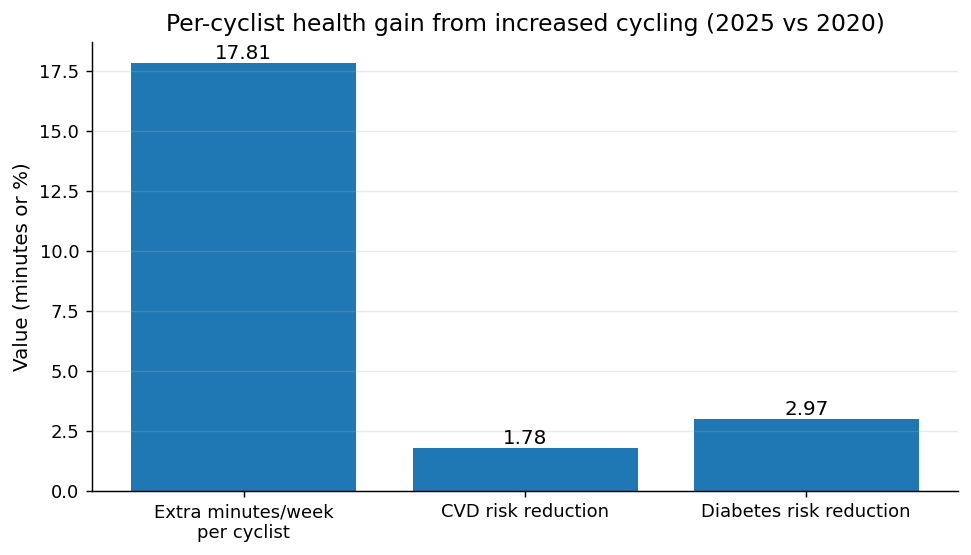

In [ ]:
fig, ax = plt.subplots(figsize=(7.6, 4.4))

labels = ["Extra minutes/week\nper cyclist", "CVD risk reduction", "Diabetes risk reduction"]
vals = [extra_min_per_cyclist_week, rr_cvd*100, rr_dia*100]

ax.bar(labels, vals)
ax.set_title("Per-cyclist health gain from increased cycling (2025 vs 2020)")
ax.set_ylabel("Value (minutes or %)")
style_axes(ax)

for i, v in enumerate(vals):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


### Per-Cyclist Health Benefits Increase Strongly with Cycling Intensity

The figure above illustrates the relationship between **additional weekly cycling time** and **individual-level health benefits**, expressed as **relative risk reduction** for cardiovascular disease (CVD) and type 2 diabetes.

The results show a clear and approximately linear dose–response relationship: as weekly cycling time increases, the associated health benefits rise steadily for both conditions.

A particularly important insight from this figure is the magnitude of benefit achieved with **relatively small increases in activity**. Increasing cycling by **60 minutes per week**—equivalent to **just 5–10 minutes of additional cycling per day**—is associated with:

- **~10% reduction in diabetes risk**
- **~6% reduction in cardiovascular disease risk**

These are substantial health improvements given the modest time investment required. For many individuals, this increase could be achieved through short daily trips, such as cycling part of a commute or incorporating brief recreational rides.

The figure also highlights that meaningful health gains occur well below high-intensity or high-volume cycling levels. Even increases of **10–30 minutes per week** yield measurable reductions in disease risk, reinforcing the idea that **small, achievable behavior changes can produce significant health benefits**.

This dose–response relationship underpins the broader analysis by demonstrating how infrastructure-enabled increases in everyday cycling can translate into **clinically meaningful reductions in chronic disease risk at the individual level**, which then scale to significant population-level impacts.


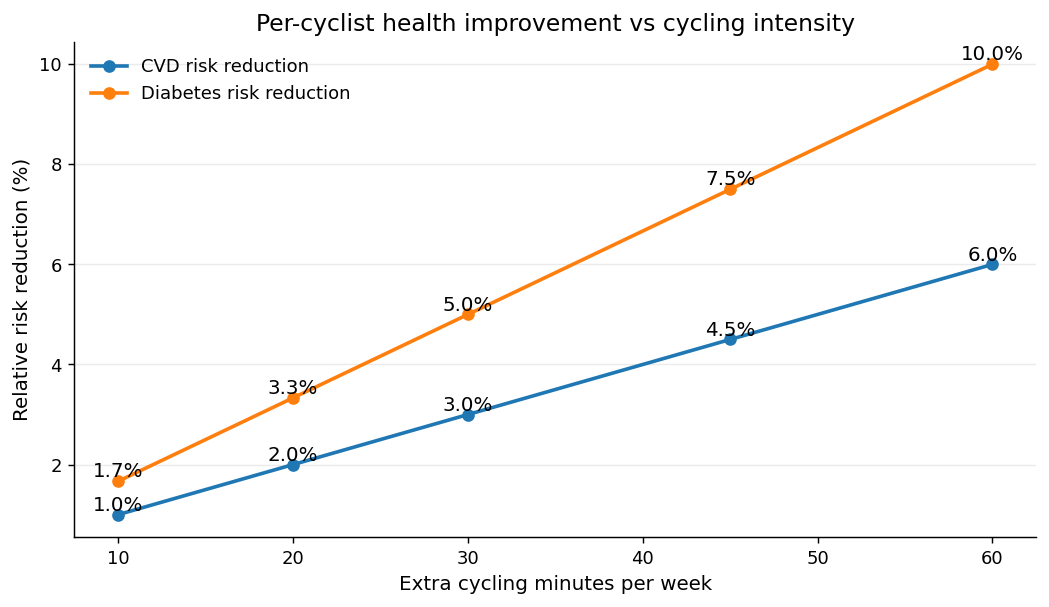

In [ ]:
# ================================
# GRAPH 2: Per-cyclist health improvement vs cycling minutes
# ================================

minutes_range = np.array([10, 20, 30, 45, 60])  # extra min/week
rr_cvd_vals = []
rr_dia_vals = []

for m in minutes_range:
    rr_cvd_vals.append(
        rr_scaled(m, RR_CVD_AT_15MIN, REFERENCE_MIN_PER_WEEK, RR_CVD_CAP) * 100
    )
    rr_dia_vals.append(
        rr_scaled(m, RR_DIABETES_AT_15MIN, REFERENCE_MIN_PER_WEEK, RR_DIABETES_CAP) * 100
    )

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8.2, 4.8))
ax.plot(minutes_range, rr_cvd_vals, marker="o", linewidth=2, label="CVD risk reduction")
ax.plot(minutes_range, rr_dia_vals, marker="o", linewidth=2, label="Diabetes risk reduction")

ax.set_title("Per-cyclist health improvement vs cycling intensity")
ax.set_xlabel("Extra cycling minutes per week")
ax.set_ylabel("Relative risk reduction (%)")
ax.legend(frameon=False)
style_axes(ax)

for x, y in zip(minutes_range, rr_cvd_vals):
    ax.text(x, y, f"{y:.1f}%", ha="center", va="bottom")

for x, y in zip(minutes_range, rr_dia_vals):
    ax.text(x, y, f"{y:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()


### Conclusion

This analysis demonstrates a clear and consistent relationship between the **expansion of cycling infrastructure in Edmonton** and **increased cycling activity** between **2020 and 2025**. Using city bicycle counter data, the study shows a sustained **~54% increase in cycling volume**, with higher participation observed across **all months**, **both weekdays and weekends**, and during both **winter and summer** periods. This pattern indicates a structural and durable shift in travel behavior rather than short-term or seasonal variation.

By translating increased cycling activity into **additional minutes of moderate physical activity per individual**, the analysis moves beyond aggregate usage metrics and focuses on **individual-level health impacts**. Established dose–response relationships from epidemiological literature are used to estimate how these additional minutes reduce the risk of **cardiovascular disease** and **type 2 diabetes** among cyclists.

The results show that even modest increases in cycling time—on the order of **5–10 additional minutes per day**—are associated with **meaningful reductions in disease risk** at the individual level. For example, increasing weekly cycling by up to **60 minutes** is associated with approximately **6% lower cardiovascular disease risk** and **10% lower diabetes risk** per individual. While these reductions may appear small in isolation, they represent clinically meaningful improvements when sustained over time and across large numbers of people.

Taken together, the findings provide strong evidence that cycling infrastructure investments not only increase cycling participation, but also deliver **tangible health benefits to individuals**. These individual-level improvements form the foundation for broader **population health gains** and **healthcare cost savings**, reinforcing the role of active transportation infrastructure as an effective public health intervention.

Overall, this project highlights how relatively modest changes in daily behavior—enabled by supportive urban infrastructure—can translate into significant and lasting improvements in individual and population health outcomes.
